# MPP for real network (whole grid)

Run the parcels model with windage for the grid with evenly distributed particles (ocean only) and calculate MPP 

## Run the model

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 11 16:39:06 2022

@author: ruijsch
"""

from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, ErrorCode, ParticleFile, ScipyParticle
from parcels import UnitConverter, Field, Variable
import numpy as np
import math
from datetime import timedelta, datetime
from datetime import timedelta as delta
from operator import attrgetter
from glob import glob
import copy



import xarray as xr
import matplotlib.pyplot as plt




In [2]:
#%%

def DeleteParticle(particle, fieldset, time):
    particle.delete()

def PrintLoc(particle, fieldset, time):
    print('(lon, lat): (%.4f, %.4f)'%(particle.lon, particle.lat))


In [3]:

#%%
#Load the data from Lorenz and define the indices
 
data_path_ocean = '/storage/shared/oceanparcels/input_data/MOi/'
# Load only a few time steps of the model output, to speed up this test simulation
ufiles = sorted(glob(data_path_ocean+'psy4v3r1/psy4v3r1-daily_U_*.nc'))[:50]
vfiles = [f.replace('_U_', '_V_') for f in ufiles]
wfiles = [f.replace('_U_', '_W_') for f in ufiles][:4]
mesh_mask = data_path_ocean + 'domain_ORCA0083-N006/coordinates.nc'

filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': ufiles},
             'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': vfiles},

             }
variables = {'U': 'vozocrtx', 'V': 'vomecrty'}
dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
              'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'}}

# Madagascar indices
indices = {'lon': np.arange(3500,4321).tolist(),
            'lat': np.arange(900, 1600).tolist()}

#%%

data_path_wind = '/storage/shared/oceanparcels/output_data/data_Mikael/ERA5/wind/'
# Load only a few time steps of the model output, to speed up this test simulation
wind_files = sorted(glob(data_path_wind+'ERA5_global_wind_monthly_*.nc'))[81:240]

# the mesh mask comes from the ocean data path
mesh_mask = data_path_ocean + 'domain_ORCA0083-N006/coordinates.nc'


#%%

data_path_bathymetry = '/storage/shared/oceanparcels/input_data/MOi/'

maskfiles = data_path_bathymetry+'domain_ORCA0083-N006/bathymetry_ORCA12_V3.3.nc'

filenames_mask = {'mask': {'lon': maskfiles, 'lat': maskfiles, 'data': maskfiles}}

variables_mask = {'mask': 'mask'}
dimensions_mask = {'mask': {'lon': 'nav_lon', 'lat': 'nav_lat'}}

# Madagascar indices
indices_mask = {'lon': np.arange(3500,4321).tolist(),
            'lat': np.arange(900, 1600).tolist()}


#%%



coastfiles = 'distance_to_coast_22_04_22.nc'

filenames_coast = {'distance': {'lon': coastfiles, 'lat': coastfiles, 'data': coastfiles}}

variables_coast = {'distance': 'distance'}
dimensions_coast = {'distance': {'lon': 'lon', 'lat': 'lat'}}

# Madagascar indices -> it already has the right indices
# indices_coast = {'lon': np.arange(3500,4321).tolist(),
#             'lat': np.arange(900, 1600).tolist()}


boxfiles = 'box.nc'

filenames_coast = {'distance': {'lon': coastfiles, 'lat': coastfiles, 'data': coastfiles}}

variables_coast = {'distance': 'distance'}
dimensions_coast = {'distance': {'lon': 'lon', 'lat': 'lat'}}




In [4]:

#%%
#Make the fieldsets for the currents, wind, land/sea mask and the coast

# note the indices argument and the 'allow time extrapolation=True' to speed up simulation
fset_currents = FieldSet.from_nemo(filenames, variables, dimensions, indices=indices) #, allow_time_extrapolation=True)


#%%

withwind = 0.03  # wind factor of 3%
if withwind:
    windfiles = {'U': wind_files,
                 'V': wind_files}
    winddimensions = {'lon': 'longitude', 
                      'lat': 'latitude', 
                      'time': 'time'}
    windvariables = {'U': 'u10', 'V': 'v10'}
    # Madagascar indices
    indices = {'lon': np.arange(0,300).tolist(),
               'lat': np.arange(300, 550).tolist()}
    fset_wind = FieldSet.from_nemo(windfiles, windvariables, winddimensions,indices=indices)#, allow_time_extrapolation=True)
    fset_wind.U.set_scaling_factor(withwind)
    fset_wind.V.set_scaling_factor(withwind)
    

#%%


fset_mask = FieldSet.from_nemo(filenames_mask, variables_mask, dimensions_mask, indices=indices_mask)
fset_coast = FieldSet.from_nemo(filenames_coast, variables_coast, dimensions_coast)

#%%

if withwind:
    fieldset = FieldSet(U=fset_currents.U + fset_wind.U, V=fset_currents.V + fset_wind.V)
else:
    fieldset = FieldSet(U=fset_currents.U, V=fset_currents.V)
    
fieldset.add_field(fset_mask.mask)
fieldset.add_field(fset_coast.distance)



         It will be opened with no decoding. Filling values might be wrongly parsed.
/nethome/6142060/parcels/parcels/field.py:248: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  timeslices = np.array(timeslices)
/nethome/6142060/parcels/parcels/field.py:250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataFiles = np.concatenate(np.array(dataFiles))


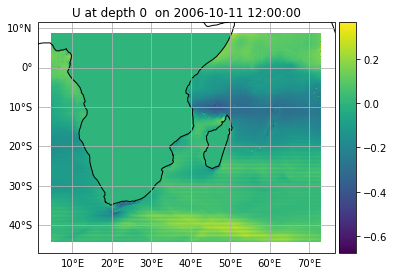

In [5]:
fset_currents.U.show()

/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/matplotlib/colors.py:620: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


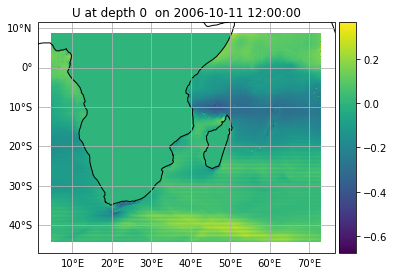

In [6]:
fieldset.U[0].show()

/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/matplotlib/colors.py:1201: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/matplotlib/colors.py:1202: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


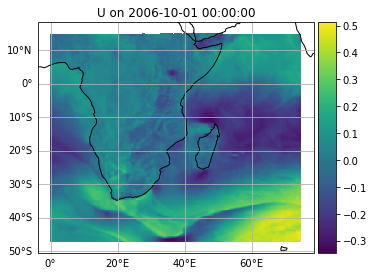

In [7]:
fieldset.U[1].show()

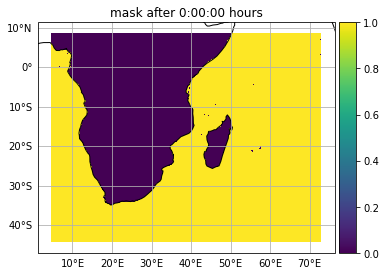

In [8]:
fieldset.mask.show()

### Choose a small portion of the grid as test

In [9]:
fieldset.mask.data[:,:,650:] = 0
fieldset.mask.data[:,:,:220] = 0
fieldset.mask.data[:,:165,:] = 0
fieldset.mask.data[:,590:,:] = 0

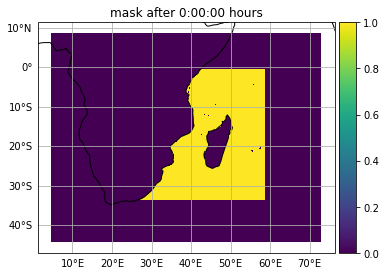

In [10]:
fieldset.mask.show()

In [11]:
X,Y = np.meshgrid(fieldset.mask.lon, fieldset.mask.lat)
X,Y

(array([[ 4.5833335,  4.6666665,  4.75     , ..., 72.75     , 72.833336 ,
         72.916664 ],
        [ 4.5833335,  4.6666665,  4.75     , ..., 72.75     , 72.833336 ,
         72.916664 ],
        [ 4.5833335,  4.6666665,  4.75     , ..., 72.75     , 72.833336 ,
         72.916664 ],
        ...,
        [ 4.5833335,  4.6666665,  4.75     , ..., 72.75     , 72.833336 ,
         72.916664 ],
        [ 4.5833335,  4.6666665,  4.75     , ..., 72.75     , 72.833336 ,
         72.916664 ],
        [ 4.5833335,  4.6666665,  4.75     , ..., 72.75     , 72.833336 ,
         72.916664 ]], dtype=float32),
 array([[-44.289257, -44.289257, -44.289257, ..., -44.289257, -44.289257,
         -44.289257],
        [-44.229576, -44.229576, -44.229576, ..., -44.229576, -44.229576,
         -44.229576],
        [-44.16983 , -44.16983 , -44.16983 , ..., -44.16983 , -44.16983 ,
         -44.16983 ],
        ...,
        [  8.551407,   8.551407,   8.551407, ...,   8.551407,   8.551407,
           8.551407

#### Find ocean coordinates 

In [12]:
p = fieldset.mask.data == 1

p
    

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

In [13]:
fieldset.mask.data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [14]:
np.shape(fieldset.mask.data)

(1, 700, 821)

In [15]:
incomp_arr = fieldset.mask.data

avg_arr = ((incomp_arr + np.roll(incomp_arr, -1))/2.0)
# array([1.5, 2.5, 3.5, 5. , 3. , 0.5])

In [16]:
p2 = np.dstack([incomp_arr, avg_arr]) == 1
p2

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

In [17]:
np.shape(np.dstack([incomp_arr, avg_arr]))

(1, 700, 1642)

In [18]:
p2[0,:,:]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [19]:
p[0,:,:]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [20]:
np.shape(X)

(700, 821)

In [21]:
box_lon = X[p[0,:,:]]

In [22]:
np.shape(box_lon)

(105574,)

In [23]:
box_lat = Y[p[0,:,:]]

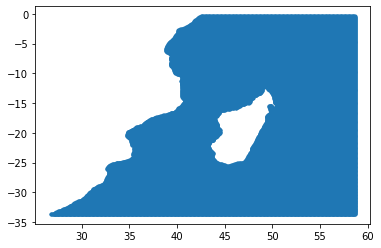

In [24]:
plt.plot(box_lon,box_lat,'.')

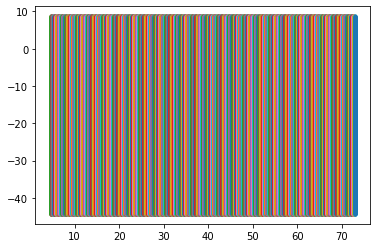

In [25]:
plt.plot(X,Y,'.')
plt.show()

In [26]:

day = 86400
#fieldset.U[0].show(show_time = 0)
#fieldset.U[1].show(show_time=10.5*day)
#fieldset.V[0].show(show_time = 0)
#fieldset.V[1].show(show_time=10.5*day)
#fieldset.mask.show()
#fieldset.dist.show()

#%%
#Custom particles and kernels

####################
# Custom Particles #
####################

class oceancc_particle(JITParticle):
    # add age of particle
    age = Variable('age', dtype=np.int32, initial=0.)
    stuck = Variable('stuck', dtype=np.int32, initial=0.)
    distance_to_coast = Variable('distance_to_coast', dtype=np.float32, to_write=True,
                        initial=fieldset.distance)
    prev_lon = Variable('prev_lon', dtype=np.float32, to_write=False,
                        initial=attrgetter('lon'))  # the previous longitude
    prev_lat = Variable('prev_lat', dtype=np.float32, to_write=False,
                        initial=attrgetter('lat'))  # the previous latitude.
    first_lon = Variable('first_lon', dtype=np.float32, to_write=False,
                        initial=attrgetter('lon'))  # the initial longitude
    first_lat = Variable('first_lat', dtype=np.float32, to_write=False,
                        initial=attrgetter('lat'))  # the initial latitude.

#%%
####################
# Particle Kernels #
####################
# Delete particles out of bounds
def deleteParticle(particle, fieldset, time):
    particle.delete()

# Particle ageing kernel
def ageingParticle(particle, fieldset, time): #age of the particle (in dt = 60 min) 
    particle.age += 1 #so age 1 = 60 minutes ( = dt)
    
def stuckParticle(particle, fieldset, time):
    if (particle.prev_lon == particle.lon) and (particle.prev_lat == particle.lat):
        particle.stuck += 1
    # Set the stored values for next iteration.
    particle.prev_lon = particle.lon
    particle.prev_lat = particle.lat

# Delete old particles
def killSwitch(particle, fieldset, time):
    if particle.age >= 24*30: #if particle is older than 30 days
        particle.delete() #delete it


def initloc(particle, fieldset, time):
    if time == 0:
        particle.first_lon = particle.lon
        particle.first_lat = particle.lat

# Delete old particles
# by repositioning them to their initial location
def killSwitch2(particle, fieldset, time):
    if particle.age >= 24*30:
        particle.lon = particle.first_lon
        particle.lat = particle.first_lat
        particle.age = 0
        particle.stuck = 0
        
def SampleDistance(particle, fieldset, time):
    particle.distance_to_coast = fieldset.distance[particle]

def AdvectionRK4_Land(particle, fieldset, time):  
    if fieldset.mask[particle] == 0: #or fieldset.distance[particle] < 10:
    #if fieldset.distance[particle] <= 10:
        #land
        particle.lon = particle.prev_lon
        particle.lat = particle.prev_lat 
        
            
    if fieldset.mask[particle] == 1: # and fieldset.distance[particle] > 10:
    #if fieldset.distance[particle] > 10:
        #ocean
        (u1, v1) = fieldset.UV[particle]
        lon1, lat1 = (particle.lon + u1*.5*particle.dt, particle.lat + v1*.5*particle.dt)
        (u2, v2) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat1, lon1, particle]
        lon2, lat2 = (particle.lon + u2*.5*particle.dt, particle.lat + v2*.5*particle.dt)
        (u3, v3) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat2, lon2, particle]
        lon3, lat3 = (particle.lon + u3*particle.dt, particle.lat + v3*particle.dt)
        (u4, v4) = fieldset.UV[time + particle.dt, particle.depth, lat3, lon3, particle]
        particle.lon += (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
        particle.lat += (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
 

### Particle release locations

In [28]:
res = 0.05 #resolution in degrees

minlon = 26
maxlon = 57
minlat = -32
maxlat = -4
grid = np.mgrid[int(minlon):int(maxlon):res,int(minlat):int(maxlat):res]+0.5
    
  

In [29]:
grid

array([[[ 26.5 ,  26.5 ,  26.5 , ...,  26.5 ,  26.5 ,  26.5 ],
        [ 26.55,  26.55,  26.55, ...,  26.55,  26.55,  26.55],
        [ 26.6 ,  26.6 ,  26.6 , ...,  26.6 ,  26.6 ,  26.6 ],
        ...,
        [ 57.35,  57.35,  57.35, ...,  57.35,  57.35,  57.35],
        [ 57.4 ,  57.4 ,  57.4 , ...,  57.4 ,  57.4 ,  57.4 ],
        [ 57.45,  57.45,  57.45, ...,  57.45,  57.45,  57.45]],

       [[-31.5 , -31.45, -31.4 , ...,  -3.65,  -3.6 ,  -3.55],
        [-31.5 , -31.45, -31.4 , ...,  -3.65,  -3.6 ,  -3.55],
        [-31.5 , -31.45, -31.4 , ...,  -3.65,  -3.6 ,  -3.55],
        ...,
        [-31.5 , -31.45, -31.4 , ...,  -3.65,  -3.6 ,  -3.55],
        [-31.5 , -31.45, -31.4 , ...,  -3.65,  -3.6 ,  -3.55],
        [-31.5 , -31.45, -31.4 , ...,  -3.65,  -3.6 ,  -3.55]]])

In [88]:
n=grid[0].size
n

8680000

In [30]:
n=grid[0].size
n

347200

In [31]:
lons = np.reshape(grid[0],n)
lats = np.reshape(grid[1],n)

In [33]:
Land = fieldset.mask
dd = 1

[lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if Land[0,0,la,lo]==dd  ]),np.array([la for lo, la in zip(lons,lats) if Land[0,0,la,lo]==dd ])]




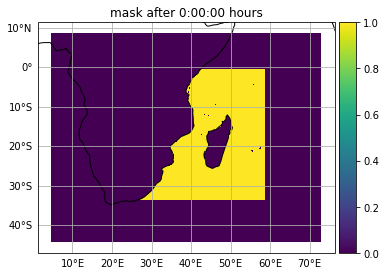

In [34]:
Land.show()

In [35]:
[lons,lats]

[array([29.7 , 29.75, 29.8 , ..., 57.45, 57.45, 57.45]),
 array([-31.5 , -31.5 , -31.5 , ...,  -3.65,  -3.6 ,  -3.55])]

In [36]:
np.save('lons_005.npy',(lons))
np.save('lats_005.npy',(lats))

In [37]:
lonss = np.load('lons_005.npy')
latss = np.load('lats_005.npy')
depths = np.ones(np.shape(lonss)[0])*0.5

In [28]:
len(lonss)

5282441

In [38]:
len(lonss)

211072

In [39]:
lonss

array([29.7 , 29.75, 29.8 , ..., 57.45, 57.45, 57.45])

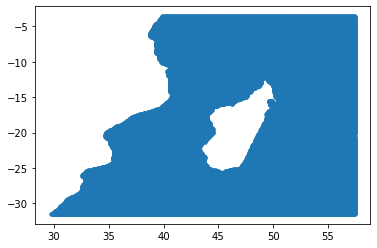

In [40]:
plt.plot(lonss,latss,'.')

### Release one particle at every 0.05 degree

In [54]:

pset = ParticleSet.from_list(fieldset=fieldset, pclass=oceancc_particle, lon=lonss, lat=latss, 
                        depth = depths, time = 60*60*24*15)


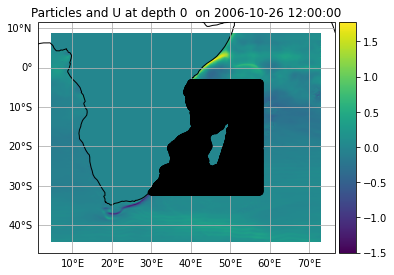

In [55]:
pset.show(field = fieldset.U[0])

In [56]:
#pset.show()

### Run the model a couple of times for 5 days

In [57]:

kernels = pset.Kernel(ageingParticle) + pset.Kernel(killSwitch) + pset.Kernel(stuckParticle) +  pset.Kernel(AdvectionRK4_Land) + pset.Kernel(SampleDistance)

output_file = pset.ParticleFile(name='2022_09_22_whole_grid_005_windage_3_day15.nc', 
                         outputdt=timedelta(hours=3))#, convert_at_end=True)

pset.execute(pyfunc=kernels, output_file=output_file, runtime=timedelta(days=5), dt=timedelta(minutes=60), verbose_progress=True, recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

output_file.close()

print('done')





sh: None: opdracht niet gevonden
INFO: Compiled Arrayoceancc_particleageingParticlekillSwitchstuckParticleAdvectionRK4_LandSampleDistance ==> /tmp/parcels-26045/liba89e752408881357045b5b880643458b_0.so
100%|█████████████████████████████| 432000.0/432000.0 [01:08<00:00, 6343.26it/s]


done


/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/matplotlib/colors.py:620: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


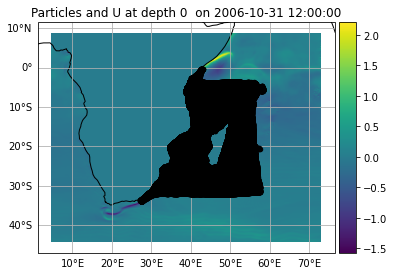

In [58]:
pset.show(field = fieldset.U[0])

In [ ]:
pset.show()

## Now put it in a temporal network

In [27]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [28]:
#output_files = sorted(glob('2022_09_12_network_stuff_windage_0_day*.nc'))

output_files = sorted(glob('2022_09_22_whole_grid_005_windage_3_day*.nc'))

In [29]:
output_files

['2022_09_22_whole_grid_005_windage_3_day0.nc',
 '2022_09_22_whole_grid_005_windage_3_day10.nc',
 '2022_09_22_whole_grid_005_windage_3_day15.nc',
 '2022_09_22_whole_grid_005_windage_3_day5.nc']

### Calculate the lon and lat values of starting and ending points
Take every 5th lon point, otherwise way too many nodes

In [30]:
parcels = xr.open_dataset(output_files[0])

start_lat = np.array(parcels.lat[:,0])
start_lon = np.array(parcels.lon.isel(obs=0))

#loc_lat = np.array(parcels.lat[:,0])[::5]
#loc_lon = np.array(parcels.lon.isel(obs=0))[::5]

In [31]:
def end_lon_lat(file):
    
    parcels = xr.open_dataset(file)
    
    end_lon = np.array(parcels.lon.isel(obs=24))
    end_lat = np.array(parcels.lat[:,-1])

    return end_lon, end_lat

In [32]:
end_lon = np.zeros((len(output_files),len(parcels.lat[:,-1])))
end_lat = np.zeros((len(output_files),len(parcels.lat[:,-1])))

for i in range(len(output_files)):
    end_lon_a, end_lat_a = end_lon_lat(output_files[i])
    end_lon[i,:] = end_lon_a
    end_lat[i,:] = end_lat_a

In [33]:
start_lon_lat = np.zeros((len(start_lon),2))

for i in range(len(start_lon)):
    start_lon_lat[i,0] = start_lon[i]
    start_lon_lat[i,1] = start_lat[i]
    
start_lon_lat

# loc_lon_lat = np.zeros((len(loc_lon),2))

# for i in range(len(loc_lon)):
#     loc_lon_lat[i,0] = loc_lon[i]
#     loc_lon_lat[i,1] = loc_lat[i]
    


array([[ 29.7 , -31.5 ],
       [ 29.75, -31.5 ],
       [ 29.8 , -31.5 ],
       ...,
       [ 57.45,  -3.65],
       [ 57.45,  -3.6 ],
       [ 57.45,  -3.55]])

In [34]:
len(start_lon)

211072

In [37]:
end_lon_lat = np.zeros((len(output_files),np.shape(end_lon)[1],2))

for i in range(len(output_files)):
    for j in range(len(start_lon)):
        end_lon_lat[i,j,0] = end_lon[i,j]
        end_lon_lat[i,j,1] = end_lat[i,j]
    
end_lon_lat

array([[[ 29.66316795, -31.51061058],
        [ 29.57928658, -31.58317947],
        [ 29.49876213, -31.64950752],
        ...,
        [ 57.25385143,  -4.40713041],
        [ 57.25184536,  -4.36680582],
        [ 57.24654815,  -4.32591746]],

       [[ 29.71290016, -31.45293045],
        [ 29.75786018, -31.45334244],
        [ 29.80704117, -31.45466232],
        ...,
        [ 57.81549016,  -4.35530341],
        [ 57.80510548,  -4.3131565 ],
        [ 57.79443472,  -4.27596737]],

       [[ 29.66625214, -31.46250153],
        [ 29.75511742, -31.45311356],
        [ 29.80280495, -31.45453072],
        ...,
        [ 57.82795098,  -4.79480615],
        [ 57.82767542,  -4.74877398],
        [ 57.82811397,  -4.70383955]],

       [[ 29.66604614, -31.46095085],
        [ 29.69283676, -31.45497513],
        [ 29.72195435, -31.4536705 ],
        ...,
        [ 57.79719196,  -3.80081977],
        [ 57.81352557,  -3.74624189],
        [ 57.82237102,  -3.69121313]]])

In [50]:
#locations = np.sort(np.concatenate((start_lon_lat, end_lon_lat,end_lon_lat2)))

#locations = loc_lon_lat

#locations

### Nodes

In [80]:
fieldset.mask.data[:,:,650:] = 0
fieldset.mask.data[:,:,:220] = 0
fieldset.mask.data[:,:165,:] = 0
fieldset.mask.data[:,590:,:] = 0

In [81]:
np.shape(X)

(700, 821)

In [82]:
X_ = X[165:590,220:650]
X_

array([[22.916666, 23.      , 23.083334, ..., 58.5     , 58.583332,
        58.666668],
       [22.916666, 23.      , 23.083334, ..., 58.5     , 58.583332,
        58.666668],
       [22.916666, 23.      , 23.083334, ..., 58.5     , 58.583332,
        58.666668],
       ...,
       [22.916666, 23.      , 23.083334, ..., 58.5     , 58.583332,
        58.666668],
       [22.916666, 23.      , 23.083334, ..., 58.5     , 58.583332,
        58.666668],
       [22.916666, 23.      , 23.083334, ..., 58.5     , 58.583332,
        58.666668]], dtype=float32)

In [83]:
Y_ = Y[165:590,220:650]
Y_

array([[-33.633324  , -33.633324  , -33.633324  , ..., -33.633324  ,
        -33.633324  , -33.633324  ],
       [-33.56391   , -33.56391   , -33.56391   , ..., -33.56391   ,
        -33.56391   , -33.56391   ],
       [-33.494446  , -33.494446  , -33.494446  , ..., -33.494446  ,
        -33.494446  , -33.494446  ],
       ...,
       [ -0.58332324,  -0.58332324,  -0.58332324, ...,  -0.58332324,
         -0.58332324,  -0.58332324],
       [ -0.49999365,  -0.49999365,  -0.49999365, ...,  -0.49999365,
         -0.49999365,  -0.49999365],
       [ -0.416663  ,  -0.416663  ,  -0.416663  , ...,  -0.416663  ,
         -0.416663  ,  -0.416663  ]], dtype=float32)

In [84]:
np.shape(X_)

(425, 430)

In [85]:
np.shape(Y_)

(425, 430)

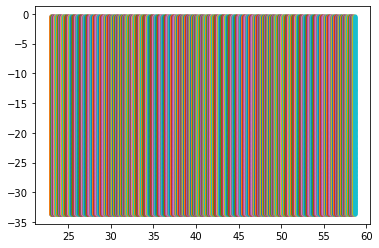

In [86]:
plt.figure()
plt.plot(X_,Y_,'.')
plt.show()

In [87]:
#X__ = X_[::2,::2]
X__ = X_[::4,::4]
X__

array([[22.916666, 23.25    , 23.583334, ..., 57.916668, 58.25    ,
        58.583332],
       [22.916666, 23.25    , 23.583334, ..., 57.916668, 58.25    ,
        58.583332],
       [22.916666, 23.25    , 23.583334, ..., 57.916668, 58.25    ,
        58.583332],
       ...,
       [22.916666, 23.25    , 23.583334, ..., 57.916668, 58.25    ,
        58.583332],
       [22.916666, 23.25    , 23.583334, ..., 57.916668, 58.25    ,
        58.583332],
       [22.916666, 23.25    , 23.583334, ..., 57.916668, 58.25    ,
        58.583332]], dtype=float32)

In [88]:
#Y__ = Y_[::2,::2]
Y__ = Y_[::4,::4]
Y__

array([[-33.633324 , -33.633324 , -33.633324 , ..., -33.633324 ,
        -33.633324 , -33.633324 ],
       [-33.355343 , -33.355343 , -33.355343 , ..., -33.355343 ,
        -33.355343 , -33.355343 ],
       [-33.076473 , -33.076473 , -33.076473 , ..., -33.076473 ,
        -33.076473 , -33.076473 ],
       ...,
       [ -1.0832688,  -1.0832688,  -1.0832688, ...,  -1.0832688,
         -1.0832688,  -1.0832688],
       [ -0.7499786,  -0.7499786,  -0.7499786, ...,  -0.7499786,
         -0.7499786,  -0.7499786],
       [ -0.416663 ,  -0.416663 ,  -0.416663 , ...,  -0.416663 ,
         -0.416663 ,  -0.416663 ]], dtype=float32)

In [89]:
p_ = p[:,165:590,220:650]
p_

array([[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]]])

In [90]:
#p__ = p_[:,::2,::2]
p__ = p_[:,::4,::4]
p__

array([[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]]])

In [91]:
box_lon_ = X_[p_[0,:,:]]

In [92]:
box_lat_ = Y_[p_[0,:,:]]

In [93]:
box_lon__ = X__[p__[0,:,:]]
box_lat__ = Y__[p__[0,:,:]]

In [94]:
box_lon__

array([26.916666, 27.25    , 27.583334, ..., 57.916668, 58.25    ,
       58.583332], dtype=float32)

In [95]:
box_lat__

array([-33.633324, -33.633324, -33.633324, ...,  -0.416663,  -0.416663,
        -0.416663], dtype=float32)

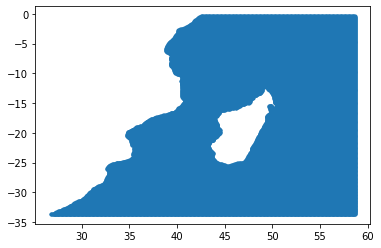

In [96]:
plt.plot(box_lon_,box_lat_,'.')

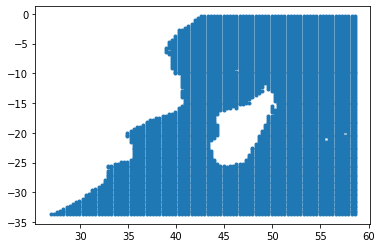

In [97]:
plt.plot(box_lon__,box_lat__,'.')

In [98]:
box_lon_lat_ = np.zeros((len(box_lon_),2))

for i in range(len(box_lon_)):
    box_lon_lat_[i,0] = box_lon_[i]
    box_lon_lat_[i,1] = box_lat_[i]

In [100]:
len(box_lon_)

105574

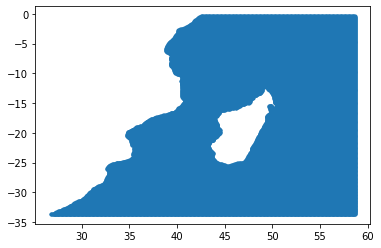

In [101]:
plt.plot(box_lon_lat_[:,0],box_lon_lat_[:,1],'.')

In [102]:
box_lon_lat__ = np.zeros((len(box_lon__),2))

for i in range(len(box_lon__)):
    box_lon_lat__[i,0] = box_lon__[i]
    box_lon_lat__[i,1] = box_lat__[i]

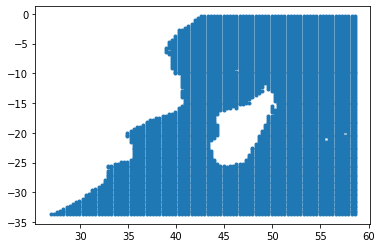

In [103]:
plt.plot(box_lon_lat__[:,0],box_lon_lat__[:,1],'.')

In [104]:
locations = box_lon_lat__

#locations

In [105]:
len(locations)

6676

In [62]:
len(locations)

26404

In [106]:
index_start = np.zeros(len(start_lon_lat))
index_end = np.zeros((len(output_files),len(start_lon_lat)))
index_start

array([0., 0., 0., ..., 0., 0., 0.])

In [107]:
start_lon_lat

array([[ 29.7 , -31.5 ],
       [ 29.75, -31.5 ],
       [ 29.8 , -31.5 ],
       ...,
       [ 57.45,  -3.65],
       [ 57.45,  -3.6 ],
       [ 57.45,  -3.55]])

In [108]:
for j in range(len(start_lon_lat)):
#for j in range(0,20):
    latvalue = start_lon_lat[j,:][1]
    lat_min = (np.abs(locations[:,1] - latvalue))
    idxlat_start = np.where(lat_min == lat_min.min())

    lonvalue = start_lon_lat[j,:][0]
    lon_min = (np.abs(locations[idxlat_start][:,0] - lonvalue))
    idxlon_start = np.where(lon_min == lon_min.min()) 
    idxlon_start = idxlon_start + idxlat_start[0][0]

    index_ = np.intersect1d(np.asarray(idxlon_start), np.asarray(idxlat_start))
    index__ = index_[0]
    #print(index_1)

    if len(index_) != 0:
        index_start[j] = index__
    else: 
        #index[i,j] = 10e10
        latvalue = idxlat_start[0][0]
        idx_min = (np.abs(idxlon - latvalue))
        a = np.argwhere(idx_min == idx_min.min())[0,1]
        index_start[j] = idxlon[0][a]

In [109]:
for i in range(len(output_files)):
    print(i)
    for j in range(len(start_lon_lat)):
        latvalue = end_lon_lat[i,j][1]
        lat_min = (np.abs(locations[:,1] - latvalue))
        idxlat_end = np.where(lat_min == lat_min.min())

        lonvalue = end_lon_lat[i,j][0]
        lon_min = (np.abs(locations[idxlat_end][:,0] - lonvalue))
        idxlon_end = np.where(lon_min == lon_min.min()) 
        idxlon_end = idxlon_end + idxlat_end[0][0]

        index_ = np.intersect1d(np.asarray(idxlon_end), np.asarray(idxlat_end))
        #print(index_1)

        if len(index_) != 0:
            index_end[i,j] = index_[0]
        else: 
            #index[i,j] = 10e10
            latvalue = idxlat[0][0]
            idx_min = (np.abs(idxlon - latvalue))
            a = np.argwhere(idx_min == idx_min.min())[0,1]
            index_end[i,j] = idxlon[0][a]

0
1
2
3


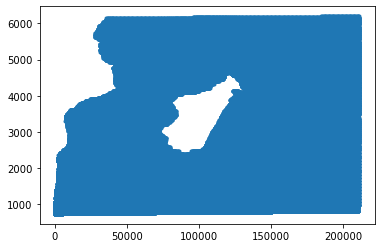

In [110]:

plt.plot(index_start[:],'.')
#plt.plot(index[4,:],'.')


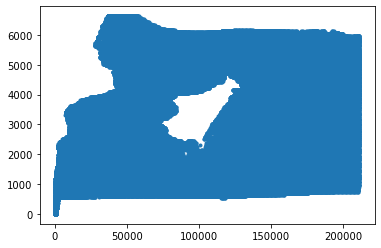

In [111]:
plt.figure()
plt.plot(index_end[2,:],'.')

In [112]:
np.save('index_start_005_lessloc.npy',(index_start))
np.save('index_end_005_lessloc.npy',(index_end))

In [113]:
index_start = np.load('index_start_005_lessloc.npy')
index_end = np.load('index_end_005_lessloc.npy')

In [114]:
index_start

array([ 733.,  733.,  733., ..., 6144., 6144., 6200.])

In [115]:
index_end

array([[ 733.,  645.,  645., ..., 6029., 6029., 6029.],
       [ 733.,  733.,  733., ..., 6031., 6031., 6031.],
       [ 733.,  733.,  733., ..., 5973., 5973., 5973.],
       [ 733.,  733.,  733., ..., 6145., 6145., 6145.]])

Particle that started in node 1161 will end up in node 561 after 20 days

In [116]:
index_start[1000:1100]

array([1161., 1161., 1161., 1244., 1244., 1244., 1244., 1244., 1244.,
       1326., 1326., 1326., 1326., 1326., 1326., 1408., 1408., 1408.,
       1408.,  738.,  738.,  738.,  738.,  738.,  738.,  824.,  824.,
        824.,  824.,  824.,  909.,  909.,  909.,  909.,  909.,  909.,
        994.,  994.,  994.,  994.,  994.,  994., 1078., 1078., 1078.,
       1078., 1078., 1078., 1161., 1161., 1161., 1161., 1161., 1244.,
       1244., 1244., 1244., 1244., 1244., 1326., 1326., 1326., 1326.,
       1326., 1326., 1408., 1408., 1408., 1408.,  739.,  739.,  739.,
        739.,  739.,  739.,  825.,  825.,  825.,  825.,  825.,  910.,
        910.,  910.,  910.,  910.,  910.,  995.,  995.,  995.,  995.,
        995.,  995., 1079., 1079., 1079., 1079., 1079., 1079., 1162.,
       1162.])

In [117]:
index_end[3,:][1000:1100]

array([ 561.,  649.,  649.,  736.,  822.,  908.,  993., 1160., 1243.,
       1243., 1326., 1408., 1408., 1408., 1408., 1408., 1408., 1408.,
       1408.,  473.,  473.,  562.,  562.,  562.,  562.,  562.,  562.,
        562.,  562.,  562.,  562.,  562.,  650.,  650.,  650.,  650.,
        650.,  650.,  650.,  650.,  650.,  562.,  562.,  562.,  561.,
        561.,  561.,  561.,  561.,  561.,  561.,  649.,  649.,  649.,
        736.,  823.,  993., 1160., 1243., 1243., 1326., 1326., 1326.,
       1326., 1408., 1408., 1489., 1408., 1408.,  473.,  562.,  562.,
        562.,  562.,  562.,  562.,  562.,  562.,  562.,  562.,  650.,
        650.,  650.,  650.,  650.,  650.,  650.,  650.,  650.,  650.,
        650.,  650.,  650.,  650.,  650.,  562.,  562.,  561.,  561.,
        561.])

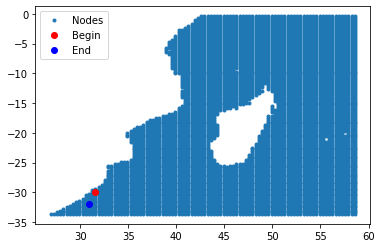

In [118]:
plt.plot(locations[:,0], locations[:,1],'.', label = 'Nodes')
plt.plot(locations[1161,0], locations[1161,1],'ro', label = 'Begin')
plt.plot(locations[561,0], locations[561,1],'bo', label = 'End')
plt.legend()

Calculate the in and out strengths for the MPP calculations

In [119]:
#calculate the out strength

(unique, counts) = np.unique(index_start, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies[:10]

array([[733.,  23.],
       [734.,  42.],
       [735.,  42.],
       [736.,  36.],
       [737.,  42.],
       [738.,  42.],
       [739.,  36.],
       [740.,  42.],
       [741.,  42.],
       [742.,  36.]])

In [120]:
#calculate the in strength

(unique, counts) = np.unique(index_end[0], return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies[:10]

array([[286.,   3.],
       [287.,  11.],
       [377.,   3.],
       [378.,  11.],
       [379.,  18.],
       [384.,   2.],
       [385.,  11.],
       [386.,  10.],
       [387.,  19.],
       [388.,  24.]])

### Build the matrix

In [121]:
G = np.zeros((len(output_files),len(locations),len(locations)))

In [122]:
G

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [123]:
np.shape(G)

(4, 6676, 6676)

Fill the matrix

In [124]:
for year in range(len(output_files)):
    print(year)
    for i,j in zip(index_end[year],index_start):
        G[year,int(i),int(j)] = G[year,int(i),int(j)] + 1

0
1
2
3


In [125]:
G

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [126]:
G[2,1000:1010,1000:1010]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [127]:
np.shape(G)

(4, 6676, 6676)

In [115]:
plt.figure(figsize = (16,9))
plt.plot(locations[:,0], locations[:,1],'k.')

for i in range(len(index_start)):
#for i in range(25300,25350):
    index1 = index_start[i]
    index2 = index_end[2][i]
    values = [int(index1), int(index2)]
    plt.plot(locations[values,0], locations[values,1])
    
    


Error in callback <function flush_figures at 0x7f813fa87790> (for post_execute):


KeyboardInterrupt: 

In [128]:
len(index_start)

211072

In [129]:
len(locations)

6676

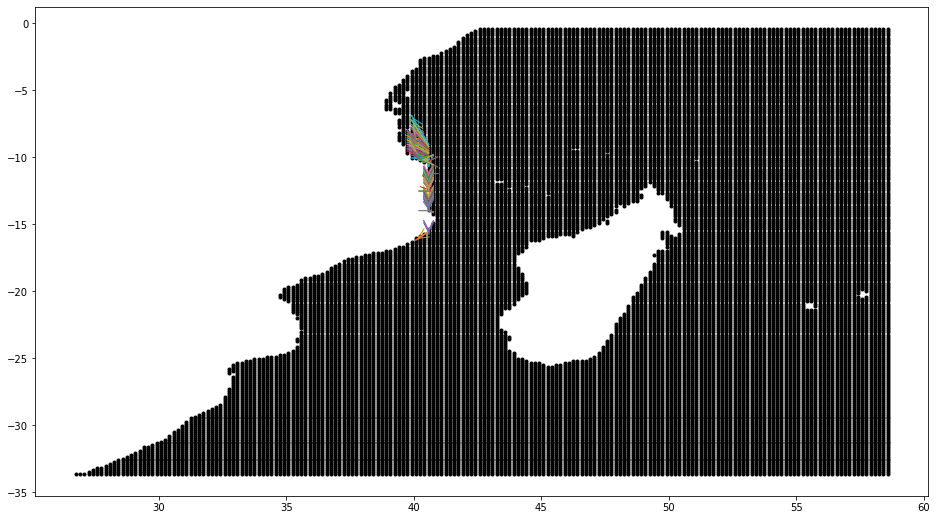

In [140]:
from matplotlib import pyplot as plt
import numpy as np


def add_arrow(line, position=None, direction='right', size=25, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )


plt.figure(figsize = (16,9))
plt.plot(locations[:,0], locations[:,1],'k.')

for i in range(41880,41980):
    index1 = index_start[i]
    index2 = index_end[3][i]
    values = [int(index1), int(index2)]
    line = plt.plot(locations[values,0], locations[values,1])[0]
    add_arrow(line)

    

It doesn't draw a line if the particle stayed in the same node, as is the case with the land-particles

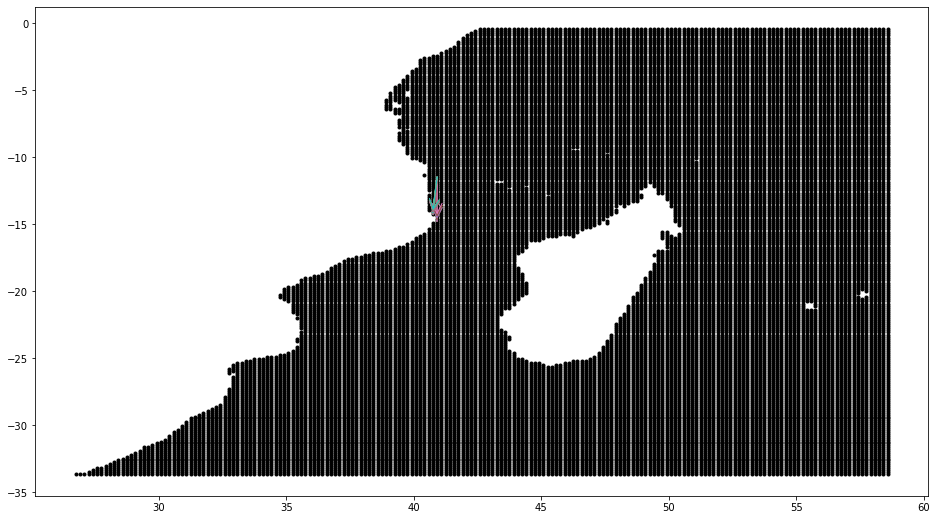

In [144]:
from matplotlib import pyplot as plt
import numpy as np


def add_arrow(line, position=None, direction='right', size=25, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )


plt.figure(figsize = (16,9))
plt.plot(locations[:,0], locations[:,1],'k.')

for i in range(1145280,1145300):
    index1 = index_start[i]
    index2 = index_end[3][i]
    values = [int(index1), int(index2)]
    line = plt.plot(locations[values,0], locations[values,1])[0]
    add_arrow(line)

    

In [141]:
locations[values,0], locations[values,1]

(array([40.58333206, 39.91666794]), array([-9.04552174, -6.89992809]))

In [142]:
index_end

array([[ 2737.,  2737.,  2561., ..., 23834., 23834., 23949.],
       [ 2911.,  2911.,  2911., ..., 23837., 23952., 23952.],
       [ 2737.,  2911.,  2911., ..., 23606., 23606., 23606.],
       [ 2737.,  2911.,  2911., ..., 24293., 24293., 24293.]])

## Network analysis 

The probability of reaching node $k_l$ at time $t_l$ under the condition of being at $k_{l−1}$ at time $t_{l−1}$ is:

$T_{k_{l-1}k_l}^{(l)} = \frac{A_{k_{l-1},k_l}^{(l)}}{s_{out}^{(l)}(k_l-1)}$

Take $l = 1$, so from $t_0$ to $t_1$. So: $k_l = k_1$ and $k_{l-1} = k_0$:

$T_{k_{0}k_1}^{(1)} = \frac{A_{k_{0},k_1}^{(1)}}{s_{out}^{(1)}(k_1-1)}$

In [130]:
T1 = np.zeros((np.shape(G)[1],np.shape(G)[1]))
T2 = np.zeros((np.shape(G)[1],np.shape(G)[1]))
T3 = np.zeros((np.shape(G)[1],np.shape(G)[1]))
T4 = np.zeros((np.shape(G)[1],np.shape(G)[1]))

In [131]:
for i in range (np.shape(G)[1]):
    for j in range(np.shape(G)[1]):
        A1 = G[0,j,i] #from node i to node j
        A2 = G[1,j,i] #from node i to node j
        A3 = G[2,j,i] #from node i to node j
        A4 = G[3,j,i] #from node i to node j
        s1 = np.sum(G[0,:,i])
        s2 = np.sum(G[1,:,i])
        s3 = np.sum(G[2,:,i])
        s4 = np.sum(G[3,:,i])
        if s1 == 0:
            T1[j,i] = 0
        if s2 == 0:
            T2[j,i] = 0
        if s3 == 0:
            T3[j,i] = 0
        if s4 == 0:
            T4[j,i] = 0
        else:
            T1[j,i] = A1/s1
            T2[j,i] = A2/s2
            T3[j,i] = A3/s3
            T4[j,i] = A4/s4

KeyboardInterrupt: 

In [132]:
i

909

In [135]:
j

992

In [134]:
np.shape(G)[1]

6676

In [ ]:
T1,T2,T3,T4

In [ ]:
T = []

In [ ]:
T.append(T1)
T.append(T2)
T.append(T3)
T.append(T4)
T

In [ ]:
np.save('T_005_lessloc.npy',(T))

In [ ]:
np.shape(T)

In [ ]:
T[2][0:10,0:5]

In [ ]:
plt.plot(locations[:,0], locations[:,1],'.', label = 'Nodes')
plt.plot(locations[105,0], locations[105,1],'.', label = 'Begin')
plt.legend()

In [ ]:
plt.plot(locations[:,0], locations[:,1],'.', label = 'Nodes')
plt.plot(locations[154,0], locations[154,1],'o', label = 'Begin')
plt.legend()

In [ ]:
#A1B = T[0][:,105] #start from node 105
A1B = T[0][:,154] #start from node 154
A1B

In [ ]:
#p = np.zeros((2,4,4))
p = np.zeros((4,191,191))
#MPP = np.zeros((4,3))
MPP = np.zeros((191,4))
MPP[:,0] = A1B
p[0,:,:] = T[0]

for i in range(0,3):
    p[i+1,:,:] = MPP[:,i]*T[i+1]
    MPP[:,i+1] = np.max(p[i+1,:,:], axis = 1)
    

In [ ]:
p

In [ ]:
MPP[0:5]

Look which MPP's are non-zero

In [ ]:
np.argwhere(MPP[:,0] != 0)

In [ ]:
MPP[np.argwhere(MPP[:,0] != 0)][:,0][:,0]

In [ ]:
np.argwhere(MPP[:,1] != 0)

In [ ]:
a_ = MPP[np.argwhere(MPP[:,1] != 0)][:,0][:,1]
a_ = MPP[np.argwhere(MPP[:,3] != 0)][:,0][:,3]
a_

In [ ]:
len(a_)

In [ ]:
for i in range(len(a_)):
    print("%.4f" % a_[i])

In [ ]:
np.argwhere(MPP[:,2] != 0)

In [ ]:
MPP[np.argwhere(MPP[:,2] != 0)][:,0][:,2]

In [ ]:
np.argwhere(MPP[:,3] != 0)

In [ ]:
len(np.argwhere(MPP[:,3] != 0))

In [ ]:
MPP[np.argwhere(MPP[:,3] != 0)][:,0][:,3]

In [ ]:
np.shape(MPP)

In [ ]:
from matplotlib import pyplot as plt
import numpy as np


def add_arrow(line, position=None, direction='right', size=25, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )


plt.figure(figsize = (16,9))
plt.plot(locations[:,0], locations[:,1],'.', label = 'Nodes')
plt.plot(locations[154,0], locations[154,1],'ro', label = 'Begin')
plt.legend()

#a = np.array([45,75,90])
a = np.argwhere(MPP[:,0] != 0)

for i in range(len(a)):
    index1 = 154
    index2 = a[i]
    values = [int(index1), int(index2)]
    line = plt.plot(locations[values,0], locations[values,1],'r')[0]
    add_arrow(line, color = 'red')
    
    
#b = np.array([15,16,75,90])
b = np.argwhere(MPP[:,1] != 0)

for j in range(len(b)):
    index1 = 154
    index2 = b[j]
    values = [int(index1), int(index2)]
    line = plt.plot(locations[values,0], locations[values,1],'b')[0]
    add_arrow(line, color = 'blue')
    
#c = np.array([0,1,15,75,90])
c = np.argwhere(MPP[:,2] != 0)

for k in range(len(c)):
    index1 = 154
    index2 = c[k]
    values = [int(index1), int(index2)]
    line = plt.plot(locations[values,0], locations[values,1],'g')[0]
    add_arrow(line, color = 'green')
    
#d = np.array([0,1,15,75,90])
d = np.argwhere(MPP[:,3] != 0)

for l in range(len(c)):
    index1 = 154
    index2 = d[l]
    values = [int(index1), int(index2)]
    line = plt.plot(locations[values,0], locations[values,1],'m')[0]
    add_arrow(line, color = 'magenta')

        
#plt.legend(['Nodes','Begin','5 days','_nolegend_','_nolegend_','10 days','_nolegend_','_nolegend_','_nolegend_','15 days','_nolegend_','_nolegend_','_nolegend_','_nolegend_','20 days'])
plt.legend(['Nodes','Begin','5 days','_nolegend_','_nolegend_','_nolegend_','_nolegend_','10 days','_nolegend_','_nolegend_','_nolegend_',
            '_nolegend_','_nolegend_','_nolegend_','_nolegend_','_nolegend_','_nolegend_','_nolegend_','_nolegend_','_nolegend_','_nolegend_',
            '_nolegend_','_nolegend_','_nolegend_','_nolegend_','_nolegend_','15 days','_nolegend_','_nolegend_','_nolegend_',
            '_nolegend_','_nolegend_','_nolegend_','_nolegend_','_nolegend_','_nolegend_','_nolegend_','_nolegend_','_nolegend_','_nolegend_',
            '_nolegend_','_nolegend_','_nolegend_','_nolegend_','_nolegend_','20 days'])

plt.show()



In [ ]:
from matplotlib import pyplot as plt
import numpy as np


def add_arrow(line, position=None, direction='right', size=25, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )


plt.figure(figsize = (16,9))
plt.plot(locations[:,0], locations[:,1],'.', label = 'Nodes')
plt.plot(locations[154,0], locations[154,1],'ro', label = 'Begin')
plt.legend()    

#d = np.array([0,1,15,75,90])
d = np.argwhere(MPP[:,3] != 0)

for l in range(len(c)):
    index1 = 154
    index2 = d[l]
    values = [int(index1), int(index2)]
    line = plt.plot(locations[values,0], locations[values,1],'m')[0]
    add_arrow(line, color = 'magenta')

        
#plt.legend(['Nodes','Begin','5 days','_nolegend_','_nolegend_','10 days','_nolegend_','_nolegend_','_nolegend_','15 days','_nolegend_','_nolegend_','_nolegend_','_nolegend_','20 days'])
plt.legend(['Nodes','Begin','20 days'])

plt.show()




In [ ]:
plt.plot(locations[:,0], locations[:,1],'.', label = 'Nodes')
plt.plot(locations[105,0], locations[105,1],'ro', label = 'Begin')

plt.plot(locations[45,0], locations[45,1],'bo', label = '5 days',markersize = 8)
plt.plot(locations[75,0], locations[75,1],'bo',markersize = 8)
plt.plot(locations[90,0], locations[90,1],'bo',markersize = 8)

plt.plot(locations[15,0], locations[15,1],'go', label = '10 days',markersize = 6)
plt.plot(locations[16,0], locations[16,1],'go',markersize = 6)
plt.plot(locations[75,0], locations[75,1],'go',markersize = 6)
plt.plot(locations[90,0], locations[90,1],'go',markersize = 6)

plt.plot(locations[0,0], locations[0,1],'yo', label = '15 days',markersize = 4)
plt.plot(locations[1,0], locations[1,1],'yo',markersize = 4)
plt.plot(locations[15,0], locations[15,1],'yo',markersize = 4)
plt.plot(locations[75,0], locations[75,1],'yo',markersize = 4)
plt.plot(locations[90,0], locations[90,1],'yo',markersize = 4)

plt.plot(locations[0,0], locations[0,1],'mo', label = '20 days',markersize = 2)
plt.plot(locations[1,0], locations[1,1],'mo',markersize = 2)
plt.plot(locations[15,0], locations[15,1],'mo',markersize = 2)
plt.plot(locations[75,0], locations[75,1],'mo',markersize = 2)
plt.plot(locations[90,0], locations[90,1],'mo',markersize = 2)

plt.legend()

### Look which paths the MPPs take

In [ ]:
p

In [ ]:
d

In [ ]:
index_ED_all = []

for i in d:
    index_ED_all.append(np.argwhere(p[3,int(i),:] == np.max(p[3,int(i),:])))


index_ED_all

In [ ]:
index_DC_all = []

for i in range(len(index_ED_all)):
    index_DC_all.append(np.argwhere(p[2,int(index_ED_all[i]),:] == np.max(p[2,int(index_ED_all[i]),:]))[0])


index_DC_all

In [ ]:
index_CB_all = []

for i in range(len(index_DC_all)):
    index_CB_all.append(np.argwhere(p[1,int(index_DC_all[i]),:] == np.max(p[1,int(index_DC_all[i]),:])))
    
index_CB_all

In [ ]:
paths_ = []

paths_.append(index_CB_all)
paths_.append(index_DC_all)
paths_.append(index_ED_all)


paths_

In [ ]:
paths = np.zeros((len(d),5))
paths

In [ ]:
paths[:,0] = 154
paths

In [ ]:
for j in range(len(d)):
    paths[j,-1] = d[j]
    for i in range(0,3):
        paths[j,i+1] = int(paths_[i][j])

In [ ]:
paths

In [ ]:
from matplotlib import pyplot as plt
import numpy as np


def add_arrow(line, position=None, direction='right', size=25, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )


plt.figure(figsize = (16,9))
plt.plot(locations[:,0], locations[:,1],'.', label = 'Nodes')
plt.plot(locations[154,0], locations[154,1],'ro', label = 'Begin')
plt.legend()    


for l in range(len(paths)):
    for k in range(4):
        index1 = paths[l,k]
        index2 = paths[l,k+1]
        values = [int(index1), int(index2)]
        line = plt.plot(locations[values,0], locations[values,1],'m',linewidth = 0.7)[0]
        add_arrow(line, color = 'magenta')

        
# #plt.legend(['Nodes','Begin','5 days','_nolegend_','_nolegend_','10 days','_nolegend_','_nolegend_','_nolegend_','15 days','_nolegend_','_nolegend_','_nolegend_','_nolegend_','20 days'])
plt.legend(['Nodes','Begin','MPPs after 20 days'])

plt.show()




In [ ]:
paths